In [43]:
import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pandas as pd
from scipy.stats import circmean, circstd

import ephem
from datetime import datetime, time, timedelta
from scipy import optimize
from mpl_toolkits.basemap import Basemap
import taylorDiagram

from numpy.fft import fft, ifft
import astropy.stats.circstats as astro_circstats

import diurnal_config

from diurnal_utils import *
from fetch_model_helper import *

import matplotlib 

font = {'weight' : 'bold',
        'size'   : 13}
label_fontdict = {'weight' : 'bold',
        'size'   : 13}
title_fontdict = {'weight' : 'bold',
        'size'   : 13}

matplotlib.rc('font', **font)

FLUX_TO_MM_HR = 60*60
HOURS_TO_RADIANS = 2*np.pi/24

In [44]:
rel_data_dir = '/export/data1/cchristo/'
save_figs_dir = '/home/cchristo/proj_tapio/diurnal_research/figs/diurnal_cycle_figs/'

input_data_dir_cm5 = rel_data_dir  + 'diurnal_analysis_results/CMIP5_regridded/grid1/' #GFDL-ESM2M/'
input_data_dir_cm6  = rel_data_dir + 'diurnal_analysis_results/CMIP6_regridded/grid1/' #GFDL-ESM4/'
input_data_dir_gpm = rel_data_dir  + 'diurnal_analysis_results/GPM_regridded/grid1/GPM/'
land_sea_mask = rel_data_dir  + 'land_sea_masks/land_sea_masks_regridded/grid1/grid1_GLDASp4_landmask_1d.nc'

In [6]:
os.listdir(input_data_dir_gpm)

['grid1_2000-06_2010-06_precip.nc']

In [45]:
rel_cmip6_path= '/export/data1/cchristo/CMIP6_precip/pr_3hr_historical/'
rel_cmip5_path = '/export/data1/cchristo/CMIP5_precip/pr_3hr_historical/'

unique_cmip6_models = list(get_unique_models(rel_cmip6_path))
unique_cmip5_models = list(get_unique_models(rel_cmip5_path))

In [46]:

ds_land_sea = xr.open_dataset(land_sea_mask)
df_land_sea = ds_land_sea.to_dataframe().astype(int)
# ds_gpm['land_sea_mask'] = ds_land_sea['GLDAS_mask']




In [129]:
# ds_gpm['phase_season']

## Take mean accross seasons for GPM (circular for phase!)

In [47]:
ds_gpm = xr.open_dataset(input_data_dir_gpm +  'grid1_2000-06_2010-06_precip.nc') #.mean(dim = 'season')
# take mean across seasons using circular mean for phase
ds_gpm_phase_year_mean = xr.apply_ufunc(circmean, ds_gpm['phase_season'], 
                                   kwargs = {'low' : 0.0, 'high' : 24.0},
                                   input_core_dims=[["season"]], 
                                   vectorize = True)
ds_gpm = ds_gpm.mean(dim = 'season')
ds_gpm['phase_season'] = ds_gpm_phase_year_mean
ds_gpm['land_sea_mask'] = ds_land_sea['GLDAS_mask']
df_gpm = ds_gpm.to_dataframe()

In [48]:
def _merge_models_into_df(model_names, input_data_dir,
                          filename = '1985-01_2006-01_precip.nc',
                          compute_year_mean_bool = False, 
                          verbose = False):
    '''Given list of model names and path to cmip files containing seasonal components, 
    open and take yearly mean (ensuring a circular mean is used for phase).'''
    objs = {}
    df = pd.DataFrame()
    for model_name_i in range(len(model_names)):  
        try:
            model_name = model_names[model_name_i]
            path_to_file = input_data_dir + model_name + '/' + filename
            ds_i = xr.open_dataset(path_to_file)
            if compute_year_mean_bool:
                ds_i_phase_year_mean = xr.apply_ufunc(circmean, ds_i['phase_season'], 
                                   kwargs = {'low' : 0.0, 'high' : 24.0},
                                   input_core_dims=[["season"]], 
                                   vectorize = True,
                                   dask = 'allowed')
                ds_i = ds_i.mean(dim = 'season')
                ds_i['phase_season'] = ds_i_phase_year_mean
            objs[model_names[model_name_i]] = ds_i.to_dataframe()
            objs[model_names[model_name_i]]['model_name'] = model_name
        
        except Exception as e:
            if verbose:
                print('Could not get ', model_name_i, ' : ', e)
    df = pd.concat(list(objs.values()), axis = 0)
    return df
    

In [49]:
%%time
df_cm6 = _merge_models_into_df(model_names = unique_cmip6_models, 
                               input_data_dir = input_data_dir_cm6, 
                               filename = 'grid1_1985-01_2006-01_precip.nc', 
                               compute_year_mean_bool = True,
                               verbose = False)
df_cm6['cmip_indentifier'] = 'CMIP6'

df_cm5 = _merge_models_into_df(model_names = unique_cmip5_models,
                               input_data_dir = input_data_dir_cm5,
                              filename = 'grid1_1985-01_2006-01_precip.nc', 
                              compute_year_mean_bool = True,
                              verbose = False)
df_cm5['cmip_indentifier'] = 'CMIP5'


# df_cm6['model_name_compare'] = df_cm6['model_name'].apply(lambda x: diurnal_config.cmip6_to_cmip5_map[x])

# df_cm5['model_name_compare'] = df_cm5['model_name']

# merge cmip5/cmip6
df_models = pd.concat((df_cm5, df_cm6), axis = 0,) #.reset_index('season')

# merge land/sea mask
df = pd.merge(df_models, df_land_sea, how = 'left', left_index = True, right_index = True)
# df = df.reset_index('season')

CPU times: user 5min 42s, sys: 2.71 s, total: 5min 45s
Wall time: 5min 45s


In [64]:
df = df.rename({'GLDAS_mask':'land_sea_mask'}, axis = 1)

In [158]:
# ys
# ds_i.to_dataframe

# list(objs.values())[0]
# df
# ds_gpm['phase_season'].isel(season = 3).plot.imshow(cmap = plt.get_cmap('twilight'), vmin = 0, vmax = 24)

In [64]:
# res.isel(cmip_model = 4 , season = 0)['phase_season'].plot.imshow()
plt.figure()
for model_name_i in range(len(model_names)):     
    model_name = model_names[model_name_i]
    objs[model_name]
    
    sns.boxplot(y = ds['phase_season'] data = ds)

SyntaxError: invalid syntax (<ipython-input-64-4ada08e4a3b0>, line 7)

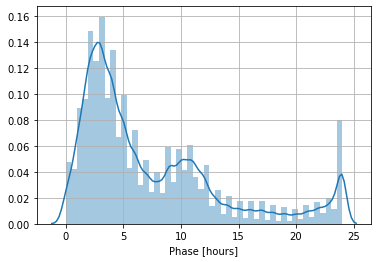

In [65]:
# df[df['model_name'] == 'GFDL-CM4'].plot(y = 'phase_season', kind = 'hist', bins = 30)
sns.distplot(df[df['model_name'] == 'GFDL-CM4']['phase_season'].values)
plt.xlabel('Phase [hours]')
plt.grid()



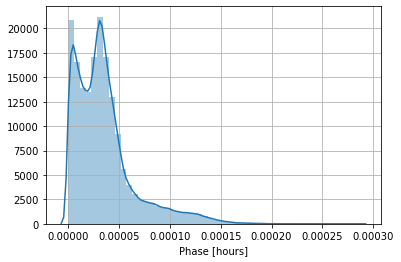

In [54]:
sns.distplot(df[df['model_name'] == 'GFDL-CM4']['mu_season'].values)
plt.xlabel('Phase [hours]')
plt.grid()

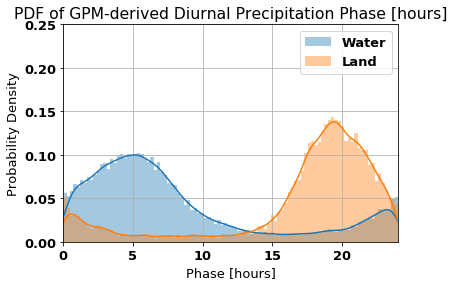

In [70]:
sns.distplot(df_gpm[df_gpm['land_sea_mask'] == 0]['phase_season'].values, label = 'Water', bins = 100)
sns.distplot(df_gpm[df_gpm['land_sea_mask'] == 1]['phase_season'].values, label = 'Land', bins = 100)
plt.xlim([0, 24])
plt.ylim([0, 0.25])
plt.xlabel('Phase [hours]')
plt.ylabel('Probability Density')
plt.title('PDF of GPM-derived Diurnal Precipitation Phase [hours]')
plt.grid()
plt.legend()
plt.savefig(save_figs_dir + 'GPM/' + 'phase_pdf_land_ocean.png', dpi = 300)

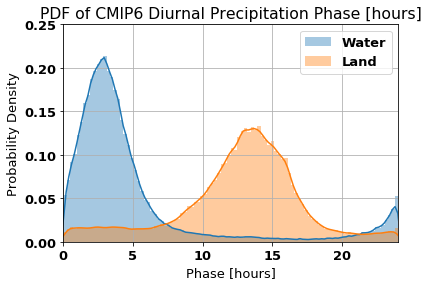

In [71]:
sns.distplot(df[(df['land_sea_mask'] == 0) & (df['cmip_indentifier'] == 'CMIP6')]['phase_season'].values, label = 'Water', bins = 100)
sns.distplot(df[(df['land_sea_mask'] == 1) & (df['cmip_indentifier'] == 'CMIP6')]['phase_season'].values, label = 'Land', bins = 100)
plt.xlim([0, 24])
plt.ylim([0, 0.25])
plt.xlabel('Phase [hours]')
plt.ylabel('Probability Density')
plt.title('PDF of CMIP6 Diurnal Precipitation Phase [hours]')
plt.grid()
plt.legend()
plt.savefig(save_figs_dir + 'CMIP6/comparisions/' + 'phase_pdf_land_ocean.png', dpi = 300)

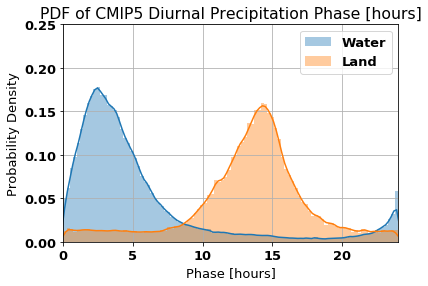

In [73]:
sns.distplot(df[(df['land_sea_mask'] == 0) & (df['cmip_indentifier'] == 'CMIP5')]['phase_season'].values, label = 'Water', bins = 100)
sns.distplot(df[(df['land_sea_mask'] == 1) & (df['cmip_indentifier'] == 'CMIP5')]['phase_season'].values, label = 'Land', bins = 100)
plt.xlim([0, 24])
plt.ylim([0, 0.25])
plt.xlabel('Phase [hours]')
plt.ylabel('Probability Density')
plt.title('PDF of CMIP5 Diurnal Precipitation Phase [hours]')
plt.grid()
plt.legend()
plt.savefig(save_figs_dir + 'CMIP5/comparisons/' + 'phase_pdf_land_ocean.png', dpi = 300)

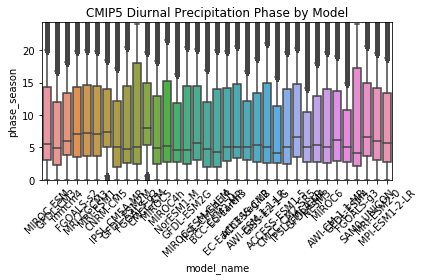

In [67]:
sns.boxplot(x = 'model_name', y = 'phase_season', data = df, whis = 0.5)
# sns.swarmplot(x = 'model_name', y = 'phase_season', data = df.sample(1000), color=".25")
plt.ylim(0, 24.3)
plt.xticks(rotation = 45)
plt.title('CMIP5 Diurnal Precipitation Phase by Model')
# plt.grid()
plt.tight_layout()
# plt.savefig(save_figs_dir + 'compare_models/' + 'box_and_whiskers_cmip5.png', dpi = 300)

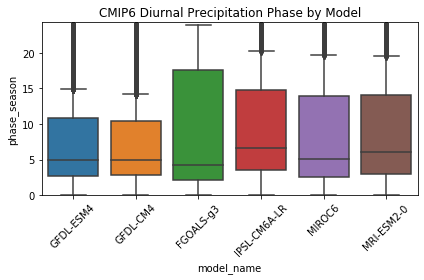

In [114]:
sns.boxplot(x = 'model_name', y = 'phase_season', data = df_cm6, whis = 0.5)
# sns.swarmplot(x = 'model_name', y = 'phase_season', data = df.sample(1000), color=".25")
plt.ylim(0, 24.3)
plt.xticks(rotation = 45)
plt.title('CMIP6 Diurnal Precipitation Phase by Model')
plt.tight_layout()
plt.savefig(save_figs_dir + 'compare_models/' + 'box_and_whiskers_cmip6.png', dpi = 300)

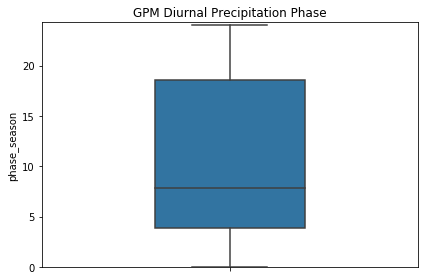

In [265]:

sns.boxplot(y = 'phase_season', data = df_gpm, whis = 0.5, width = 0.4)
plt.ylim(0, 24.3)
plt.xticks(rotation = 45)
plt.title('GPM Diurnal Precipitation Phase')
plt.tight_layout()
plt.savefig(save_figs_dir + 'compare_models/' + 'box_and_whiskers_gpm.png', dpi = 300)

In [70]:
# df_cm6


In [74]:
# plt.figure(figsize = (8,5))
# sns.boxplot(x = 'model_name', y = 'phase_season', hue = 'land_sea_mask', data = df_cm6, whis = 0.5)
# # sns.swarmplot(x = 'model_name', y = 'phase_season', data = df.sample(1000), color=".25")
# plt.ylim(0, 24.3)
# plt.xticks(rotation = 45)
# plt.title('CMIP6 Diurnal Precipitation Phase by Model [land/sea]')
# plt.tight_layout()
# plt.legend(loc  = 1)
# plt.savefig(save_figs_dir + 'compare_models/' + 'box_and_whiskers_land_sea_cmip6.png', dpi = 300)

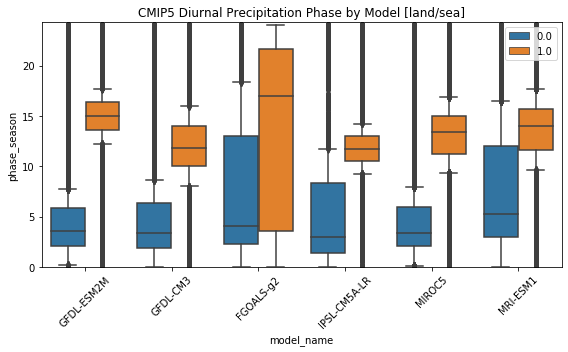

In [149]:
plt.figure(figsize = (8,5))
sns.boxplot(x = 'model_name', y = 'phase_season', hue = 'land_sea_mask', data = df_cm5, whis = 0.5)
# sns.swarmplot(x = 'model_name', y = 'phase_season', data = df.sample(1000), color=".25")
plt.ylim(0, 24.3)
plt.xticks(rotation = 45)
plt.title('CMIP5 Diurnal Precipitation Phase by Model [land/sea]')
plt.tight_layout()
plt.legend(loc  = 1)
plt.savefig(save_figs_dir + 'compare_models/' + 'box_and_whiskers_land_sea_cmip5.png', dpi = 300)

In [159]:
# df_gpm
df_gpm['source'] = 'gpm'

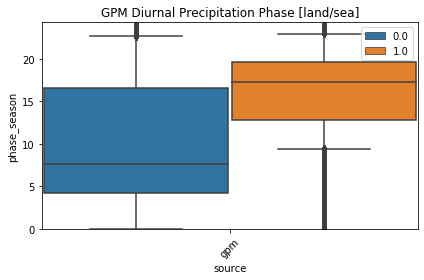

In [160]:

sns.boxplot(x = 'source', y = 'phase_season', data = df_gpm, whis = 0.5, hue = 'land_sea_mask', width = 1)
plt.ylim(0, 24.3)
plt.xticks(rotation = 45)
plt.title('GPM Diurnal Precipitation Phase [land/sea]')
plt.tight_layout()
plt.legend(loc  = 1)
plt.savefig(save_figs_dir + 'compare_models/' + 'box_and_whiskers_gpm_land_sea.png', dpi = 300)

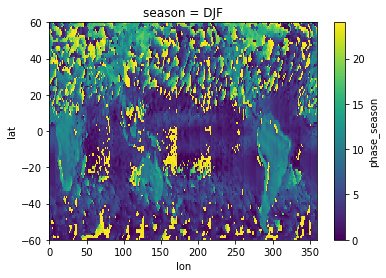

In [253]:
# os.listdir(input_data_dir )
objs[0].isel(season = 0)['phase_season'].plot.imshow()

# ds_i

In [9]:
input_data_dir_cm5

'/export/data1/cchristo/diurnal_analysis_results/CMIP5/'

In [10]:
ds = xr.open_dataset(input_data_dir_cm5  + 'GFDL-CM3/' + '1985-01_2006-01_precip.nc')
ds_diurnal_means = xr.open_dataset(input_data_dir_cm5 + 'GFDL-CM3/' + '1985-01_2006-01_precip_diurnal_means.nc')

In [ ]:
# ds.isel(season = 2)['mu_season'].plot.imshow(cmap = plt.get_cmap('gist_ncar')) 
ds.isel(season = 0)['phase_season'].plot.imshow(cmap = plt.get_cmap('twilight'), vmin = 0, vmax = 24)

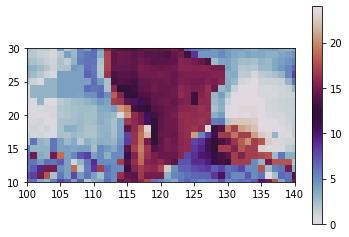

In [153]:
plt.imshow(ds.isel(season = 2)['phase_season'].values, origin = 'lower',
           cmap = plt.get_cmap('twilight'), vmin = 0, vmax = 24)
plt.axis([100,140, 10, 30])
plt.colorbar()

In [28]:
# make_four_panel(ds , 
#                 lats = ds['lat'].values, 
#                 lons = ds['lon'].values,
#                 vmin = 0, vmax = 24, 
#                 cmap = plt.get_cmap('twilight'),
#                 title = r'$\Phi$',
# #                 axis = plt.axis([220, 300, 10, 50]), 
#                 save_fig_path= None)

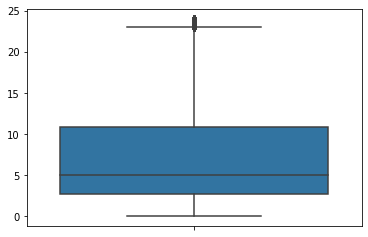

In [185]:
sns.boxplot(y = ds['phase_season'].values)

# compute error statistics


In [167]:
df_cmip6 = df[df['cmip_indentifier'] == 'CMIP6']
df_cmip5 = df[df['cmip_indentifier'] == 'CMIP5']
field = 'phase_season'
# season = 'DJF'
# df

df_for_stats = df_cmip6.copy()
df_for_stats['ampl_season'] = FLUX_TO_MM_HR*df_for_stats['ampl_season']
df_for_stats['mu_season'] = FLUX_TO_MM_HR*df_for_stats['mu_season']
# df_for_stats = df_for_stats[df_for_stats['season'] == season]

# df_for_stats_true = df_gpm[df_gpm['season'] == season]
df_for_stats_true = df_gpm.copy()


In [75]:
def circdiff(A,B, max_val = 24):
#     A_rad, B_rad = A*HOURS_TO_RADIANS, B*HOURS_TO_RADIANS 
    abs_diff =  max_val/2 - abs(abs(A - B) - max_val/2)
    return abs_diff
        

In [400]:
HOURS_TO_RADIANS = 2*np.pi/24
HOURS_TO_RADIANS 

0.2617993877991494

In [402]:
np.degrees(10 - 360)

-20053.522829578815

In [168]:
df_lat_lon_mean = df_for_stats.groupby(['lat','lon']).mean()
# df_lat_lon_err = df_lat_lon_mean - df_for_stats_true
df_lat_lon_err = circdiff(df_lat_lon_mean, df_for_stats_true)
cmips_err_ds = xr.Dataset.from_dataframe(df_lat_lon_err)
cmips_mean_ds = xr.Dataset.from_dataframe(df_lat_lon_mean)

In [362]:
circdiff(2, 1)

1.0

In [98]:
ds_gpm['mu_season'].mean() - cmips_mean_ds['mu_season'].mean()

<xarray.DataArray 'mu_season' ()>
array(0.13031464)

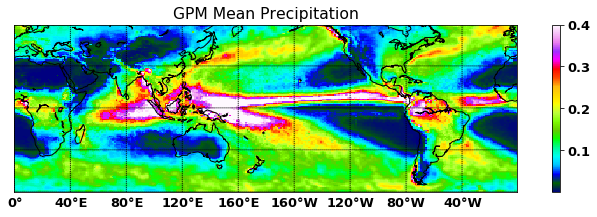

In [106]:
make_single_plot(ds_gpm['mu_season'], 
                 title = r'GPM Mean Precipitation',
                 cmap = plt.get_cmap('gist_ncar'), vmax = 0.4)
plt.savefig(save_figs_dir + 'GPM/' + 'mu_mean_spatial.png', dpi = 300)

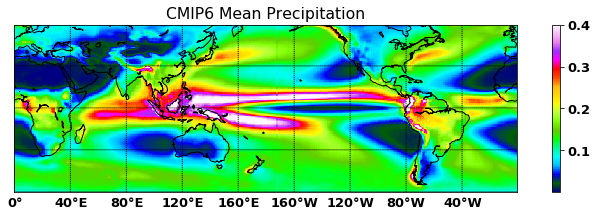

In [111]:
make_single_plot(cmips_mean_ds['mu_season'], 
                 title = r'CMIP6 Mean Precipitation',
                  cmap = plt.get_cmap('gist_ncar'), vmax = 0.4)
plt.savefig(save_figs_dir + 'CMIP6/all_models/' + 'mu_mean_spatial.png', dpi = 300)

In [112]:
ds_gpm['mu_season'].mean() - cmips_mean_ds['mu_season'].mean()

<xarray.DataArray 'mu_season' ()>
array(0.00112189)

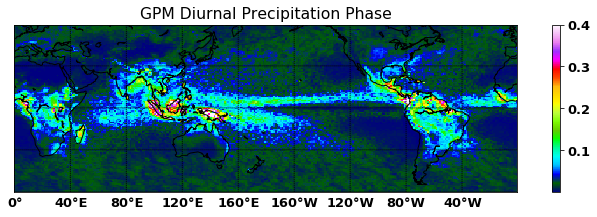

In [79]:
make_single_plot(ds_gpm['ampl_season'], 
                 title = r'GPM Diurnal Precipitation Phase',
                 cmap = plt.get_cmap('gist_ncar'), vmax = 0.4)
plt.savefig(save_figs_dir + 'GPM/' + 'ampl_mean_spatial.png', dpi = 300)

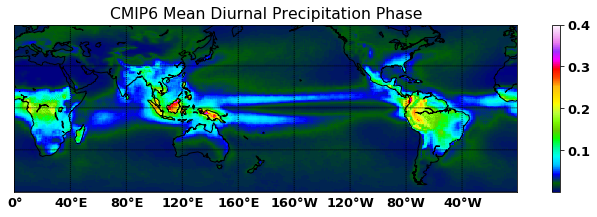

In [105]:
make_single_plot(cmips_mean_ds['ampl_season'], 
                 title = r'CMIP6 Mean Diurnal Precipitation Phase',
                  cmap = plt.get_cmap('gist_ncar'), vmax = 0.4)
plt.savefig(save_figs_dir + 'CMIP6/all_models/' + 'ampl_mean_spatial.png', dpi = 300)

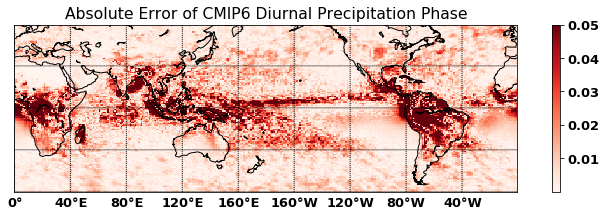

In [91]:
make_single_plot(cmips_err_ds['ampl_season'], 
                 title = r'Absolute Error of CMIP6 Diurnal Precipitation Phase',
                 cmap = plt.get_cmap('Reds'),vmax = 0.05)
plt.savefig(save_figs_dir + 'compare_models/' + 'ampl_abs_error_spatial.png', dpi = 300)

In [282]:
%run diurnal_utils.py

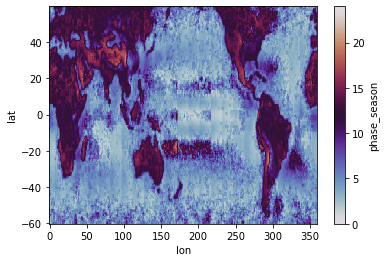

In [162]:
cmips_mean_ds[field].plot.imshow(cmap = plt.get_cmap('twilight'), vmin = 0, vmax = 24)
# (cmips_mean_ds[field]*10000).plot.imshow(cmap = plt.get_cmap('gist_ncar'))

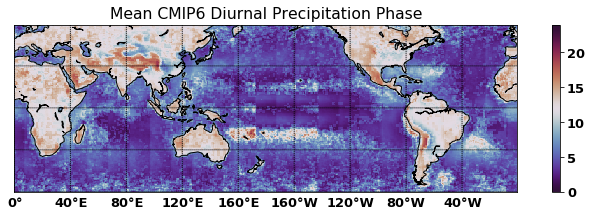

In [104]:
%run diurnal_utils.py
# cmips_mean_ds[field].values
make_single_plot(cmips_mean_ds['phase_season'], 
                 title = r'Mean CMIP6 Diurnal Precipitation Phase',
                 cmap = plt.get_cmap('twilight_shifted'),
                 vmin = 0, vmax = 24)
# isinstance(cmips_mean_ds[field])
plt.savefig(save_figs_dir + 'CMIP6/all_models/' + 'phase_mean_spatial.png', dpi = 300)

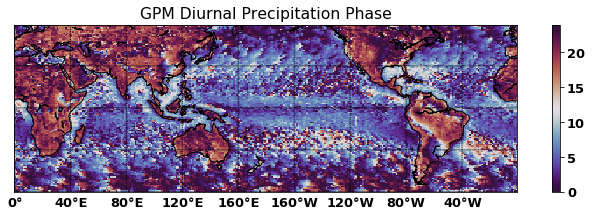

In [102]:
make_single_plot(ds_gpm['phase_season'], 
                 title = r'GPM Diurnal Precipitation Phase',
                 cmap = plt.get_cmap('twilight_shifted'),
                 vmin = 0, vmax = 24)
plt.savefig(save_figs_dir + 'GPM/' + 'phase_mean_spatial.png', dpi = 300)
# ds_gpm[field].plot.imshow(cmap = plt.get_cmap('twilight'), vmin = 0, vmax = 24)
# ds_gpm[field].plot.imshow(cmap = plt.get_cmap('gist_ncar'))

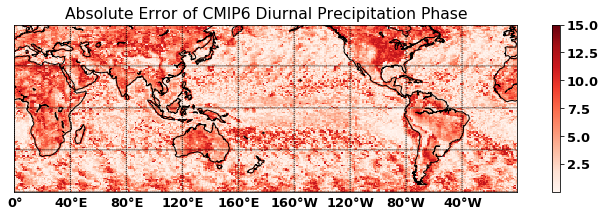

In [103]:
# cmips_err_ds[field].plot.imshow(cmap = plt.get_cmap('gist_ncar'), vmin = -5, vmax = 5)
# cmips_err_ds[field].plot.imshow(cmap = plt.get_cmap('seismic_r'))
make_single_plot(cmips_err_ds['phase_season'], 
                 title = r'Absolute Error of CMIP6 Diurnal Precipitation Phase',
                 cmap = plt.get_cmap('Reds'), vmax = 15)
#                  vmin = 0, vmax = 3)
plt.savefig(save_figs_dir + 'compare_models/' + 'phase_abs_error_spatial.png', dpi = 300)

# Taylor Plots

In [121]:
# gpm_std = df_gpm[field].std()
gpm_std =  circstd(df_gpm[field])

In [122]:
def circrmse(A, B):
    diff = circdiff(A, B)
    return np.sqrt((np.sum((diff)**2)/len(diff)))

In [169]:
from astropy import units as u
model_error_stats = {}

HOURS_TO_RADIANS = 2*np.pi/24
# HOURS_TO_RADIANS = 360.0/24
for model_name, df_i in df_for_stats.groupby('model_name'):
    diff  = df_i[field] - df_gpm[field]
    rmse = np.sqrt(np.mean((diff.values)**2))
    model_i_corr = np.corrcoef(df_i[field].values, df_gpm[field].values)[0,1]
#     model_i_corr = astro_circstats.circcorrcoef(df_i[field].values * HOURS_TO_RADIANS,  
#                              df_gpm[field].values * HOURS_TO_RADIANS)
    
    model_i_std = circstd(df_i[field].values, low = 0.0, high = 24.0)
    
    model_error_stats[model_name] = [model_i_std, model_i_corr, rmse]
#     plt.figure()
#     plt.scatter(df_i[field].values, df_gpm[field].values, s=0.01)
    
#     model_name
#     print(name)

In [228]:
astro_circstats.circcorrcoef(df_i[field].values * HOURS_TO_RADIANS,  
                             df_gpm[field].values * HOURS_TO_RADIANS)

-0.05755733198688629

In [234]:
model_i_corr

<Quantity -0.05755733>

In [224]:
# np.corrcoef
# model_error_stats
# plt.imshow(df_i[field].values * (2*np.pi/24), origin = 'lower')


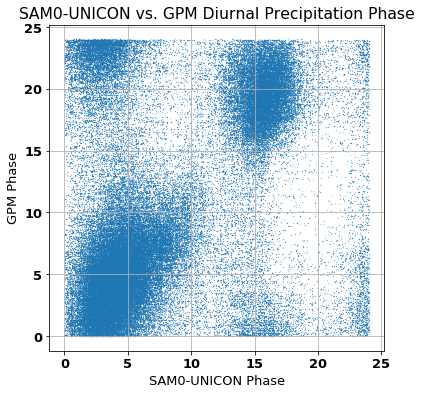

In [153]:
plt.figure(figsize = (6,6))
plt.scatter(df_i[field].values, 
            df_gpm[field].values, 
            s=0.02)
plt.xlabel(model_name + ' Phase')
plt.ylabel('GPM Phase')
plt.title( model_name + ' vs. GPM Diurnal Precipitation Phase')
plt.grid()
# plt.savefig(save_figs_dir + 'compare_models/taylor_plots/' + 'sample_scatter_phases.png', dpi = 300)

In [227]:
np.corrcoef(df_i[field].values, df_gpm[field].values)

array([[1.        , 0.33951749],
       [0.33951749, 1.        ]])

In [70]:
# df.groupby('season')

In [185]:
# Create Taylor Diagram
# import taylorDiagram
# %%capture
%run taylorDiagram.py

In [186]:
# gpm_std


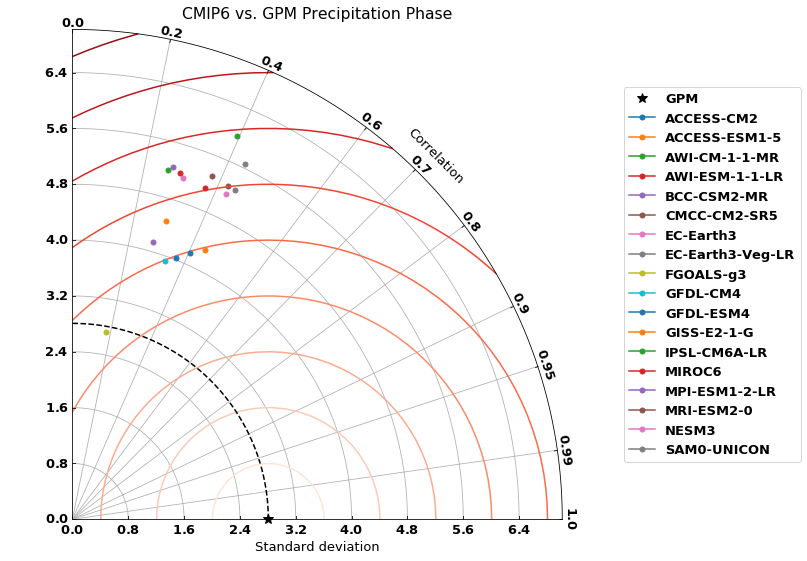

In [170]:
fig = plt.figure(figsize = (13,8))
# plt.title('Test')
taylor_diag = taylorDiagram.TaylorDiagram(gpm_std, 
                                          fig = fig, 
                                          label = 'GPM', 
                                          extend = False,
                                          srange=(0, 2.5)
                                          )
taylor_diag.add_contours(cmap = plt.get_cmap('Reds'), levels = 10)
taylor_diag.add_grid()

for model_name in list(model_error_stats.keys()):
#     print(model_error_stats[model_name])
    taylor_diag.add_sample(stddev = model_error_stats[model_name][0], 
                           corrcoef = model_error_stats[model_name][1], 
                           marker = '.', 
                           label = model_name, 
                           markersize = 10)

# plt.legend()
plt.legend(loc = 'center left', bbox_to_anchor=(1.1,0.5))
plt.title('CMIP6 vs. GPM Precipitation Phase')
plt.tight_layout()
plt.savefig(save_figs_dir + 'compare_models/taylor_plots/' + 'all_cmip6.png', dpi = 300)

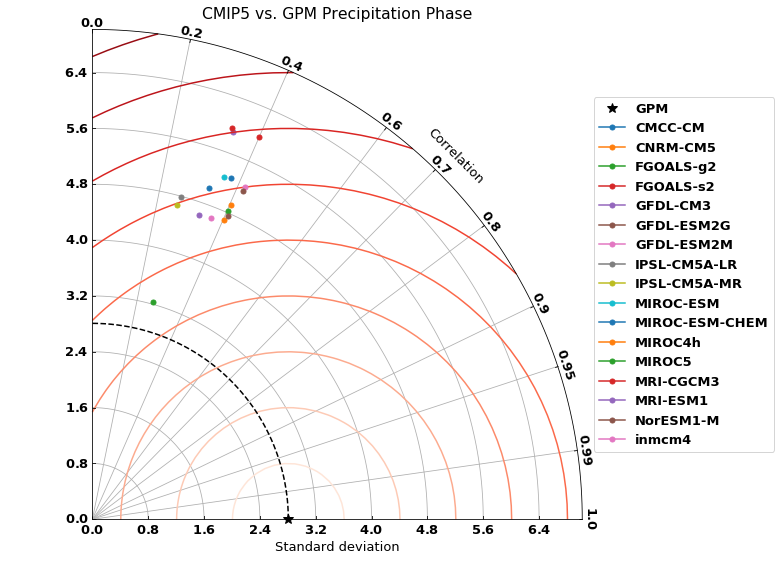

In [165]:
fig = plt.figure(figsize = (13,8))
# plt.title('Test')
taylor_diag = taylorDiagram.TaylorDiagram(gpm_std, 
                                          fig = fig, 
                                          label = 'GPM',
                                           srange=(0, 2.5))
taylor_diag.add_contours(cmap = plt.get_cmap('Reds'), levels = 10)
taylor_diag.add_grid()

for model_name in list(model_error_stats.keys()):
#     print(model_error_stats[model_name])
    taylor_diag.add_sample(stddev = model_error_stats[model_name][0], 
                           corrcoef = model_error_stats[model_name][1], 
                           marker = '.', 
                           label = model_name, 
                           markersize = 10)

# plt.legend()
plt.legend(loc = 'center left', bbox_to_anchor=(1,0.5))

plt.title('CMIP5 vs. GPM Precipitation Phase')
plt.tight_layout()
plt.savefig(save_figs_dir + 'compare_models/taylor_plots/' + 'all_cmip5.png', dpi = 300)